In [1]:
import pandas as pd
import numpy as np
from tensorflow.keras import layers, Sequential, Input, Model
from tensorflow.keras.layers import Concatenate
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import datetime

In [ ]:
# Load the dataset
data = pd.read_csv("c:/MBAN- Schulich/MBAN- Sem 2/Data Science 2/Final Exam/Recipe Reviews and User Feedback Dataset.csv")

In [ ]:
# --- 1. Target Variable Refinement ---
# Sentiment Categories
def categorize_sentiment(stars):
    if stars >= 4:
        return "Positive"
    elif stars == 3:
        return "Neutral"
    else:
        return "Negative"

data['sentiment_category'] = data['stars'].apply(categorize_sentiment)

# Engagement Categories
data['engagement_score'] = data['thumbs_up'] + data['reply_count']
engagement_threshold = data['engagement_score'].median()

def categorize_engagement(score):
    return "High" if score > engagement_threshold else "Low"

data['engagement_category'] = data['engagement_score'].apply(categorize_engagement)

In [5]:
# --- 2. Feature Engineering ---
# Normalize Reputation
data['normalized_reputation'] = data['user_reputation'] / data['user_reputation'].max()

# Time-Based Features
data['review_date'] = pd.to_datetime(data['created_at'], unit='s')
data['review_year'] = data['review_date'].dt.year
data['review_month'] = data['review_date'].dt.month
data['is_holiday_season'] = data['review_month'].apply(lambda x: 1 if x in [11, 12] else 0)

In [6]:
# --- 3. Preprocessing ---
# Tokenize and Pad Text
X = data['text'].fillna("no_comment").values
y = pd.get_dummies(data['sentiment_category']).values

# Split Data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Tokenizer Setup
tokenizer = Tokenizer(num_words=20000, oov_token="<UNK>")
tokenizer.fit_on_texts(X_train)

# Preprocess Text
def preprocess_text_data(X, tokenizer, max_len):
    seq = tokenizer.texts_to_sequences(X)
    seq = pad_sequences(seq, maxlen=max_len, padding='post', truncating='post')
    return seq

max_len = 100
X_train_seq = preprocess_text_data(X_train, tokenizer, max_len)
X_val_seq = preprocess_text_data(X_val, tokenizer, max_len)
X_test_seq = preprocess_text_data(X_test, tokenizer, max_len)

# Numerical Features
numerical_features = ['normalized_reputation', 'is_holiday_season']
numerical_data = data[numerical_features].values
numerical_train = numerical_data[:len(X_train_seq)]
numerical_val = numerical_data[len(X_train_seq):len(X_train_seq) + len(X_val_seq)]
numerical_test = numerical_data[-len(X_test_seq):]

In [7]:
# --- 4. Hybrid Model ---
# Input layers
text_input = Input(shape=(max_len,))
numerical_input = Input(shape=(numerical_train.shape[1],))

# Text Embedding and LSTM-CNN Layers
embedding_layer = layers.Embedding(input_dim=20000, output_dim=64)(text_input)
conv_layer = layers.Conv1D(filters=128, kernel_size=5, activation='relu')(embedding_layer)
pooling_layer = layers.MaxPooling1D(pool_size=2)(conv_layer)
lstm_layer = layers.Bidirectional(layers.LSTM(64))(pooling_layer)

# Combine Text and Numerical Features
concat_layer = Concatenate()([lstm_layer, numerical_input])
dense_layer = layers.Dense(64, activation='relu')(concat_layer)
output_layer = layers.Dense(3, activation='softmax')(dense_layer)  # 3 Sentiment Categories

# Compile Model
enhanced_model = Model(inputs=[text_input, numerical_input], outputs=output_layer)
enhanced_model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train Model
history = enhanced_model.fit(
    [X_train_seq, numerical_train], y_train,
    validation_data=([X_val_seq, numerical_val], y_val),
    epochs=10, batch_size=128
)

Epoch 1/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 15s 103ms/step - accuracy: 0.8084 - loss: 0.6136 - val_accuracy: 0.8463 - val_loss: 0.4472
Epoch 2/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8589 - loss: 0.4083 - val_accuracy: 0.8633 - val_loss: 0.4102
Epoch 3/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.8932 - loss: 0.3264 - val_accuracy: 0.8609 - val_loss: 0.4298
Epoch 4/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 93ms/step - accuracy: 0.9068 - loss: 0.2746 - val_accuracy: 0.8460 - val_loss: 0.4921
Epoch 5/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 91ms/step - accuracy: 0.9230 - loss: 0.2335 - val_accuracy: 0.8414 - val_loss: 0.4815
Epoch 6/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 89ms/step - accuracy: 0.9340 - loss: 0.2032 - val_accuracy: 0.8436 - val_loss: 0.5346
Epoch 7/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 92ms/step - accuracy: 0.9471 - loss: 0.1740 - val_accuracy: 0.8353 - val_loss: 0.5787
Epoch 8/10
86/86 ━━━━━━━━━━━━━━━━━━━━ 8s 94ms/step - accuracy: 0.9498 - loss: 0.1506 - val_accuracy: 0.8416 -

In [8]:
# --- 5. Evaluation ---
# Predictions
predictions = enhanced_model.predict([X_test_seq, numerical_test])
predicted_classes = predictions.argmax(axis=1)
true_classes = y_test.argmax(axis=1)

# Classification Report and Confusion Matrix
print("Classification Report:")
print(classification_report(true_classes, predicted_classes, target_names=["Negative", "Neutral", "Positive"]))

print("Confusion Matrix:")
print(confusion_matrix(true_classes, predicted_classes))

114/114 ━━━━━━━━━━━━━━━━━━━━ 3s 19ms/step
Classification Report:
              precision    recall  f1-score   support

    Negative       0.31      0.40      0.35       430
     Neutral       0.23      0.23      0.23        98
    Positive       0.91      0.88      0.89      3109

    accuracy                           0.80      3637
   macro avg       0.48      0.50      0.49      3637
weighted avg       0.82      0.80      0.81      3637

Confusion Matrix:
[[ 170   30  230]
 [  34   23   41]
 [ 336   49 2724]]


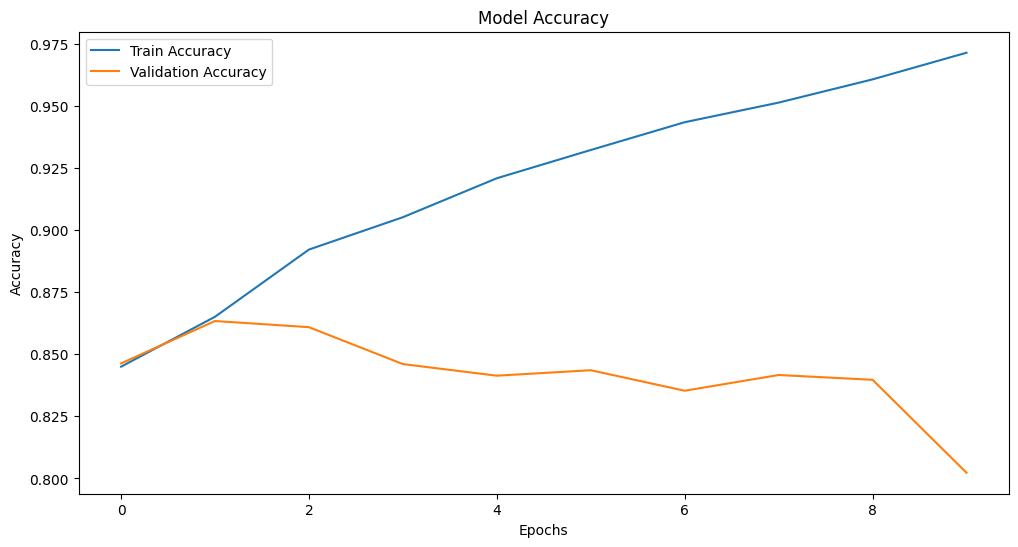

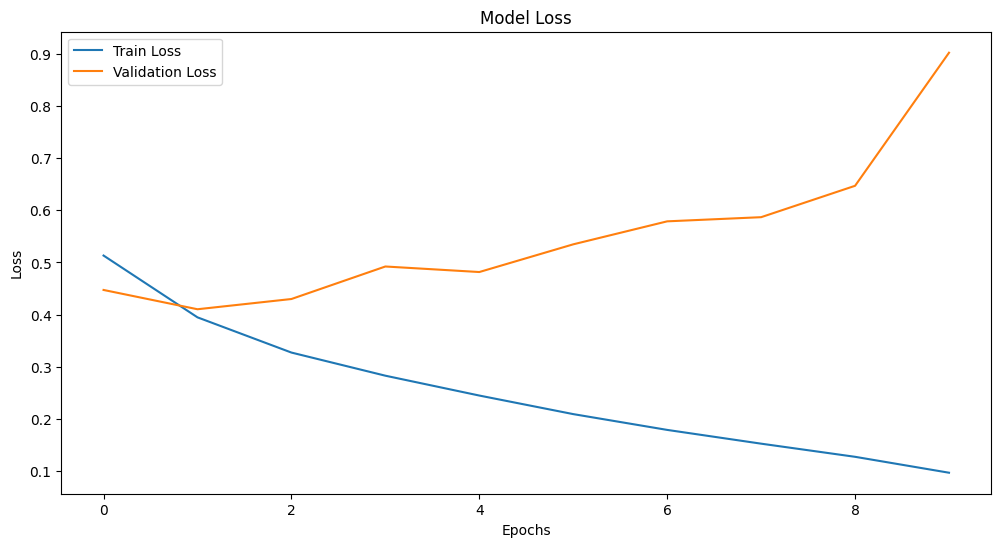

In [9]:
# Plot Accuracy and Loss Trends
def plot_history(history):
    plt.figure(figsize=(12, 6))
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history)